# Visualise Test Results

This notebook merely *visualises* the results that are run by each of the individual scripts in this directory.

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

import numpy as np

from py21cmmc.mcmc import analyse
from py21cmmc import yaml

from mpl_toolkits.axes_grid1 import make_axes_locatable

from powerbox.tools import get_power

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import py21cmmc
py21cmmc.__version__

'0.1.0'

## Gridded Baselines, No Noise, No Foregrounds

### Conceptual Checks

In this section, we check a few plots of various quantities to make sure we understand "what's really going on".

Show the baseline positions (remember we are putting them at a regular grid)

Text(0, 0.5, 'y (m)')

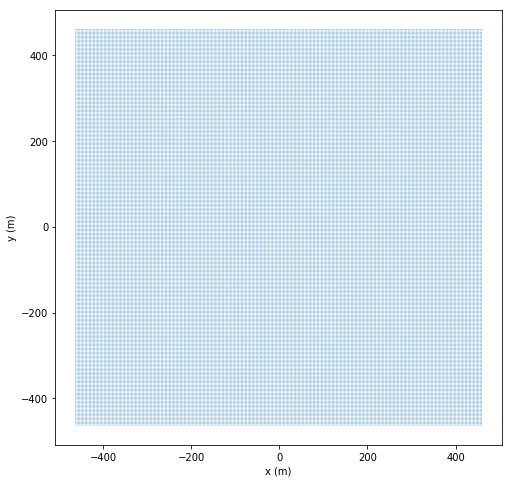

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(likelihood.baselines[:,0], likelihood.baselines[:,1], s=2, marker='.', edgecolor='none')
plt.xlabel("x (m)")
plt.ylabel("y (m)")

Show the underlying simulation brightness temp:

Existing z=8.599200000000002 perturb_field boxes found and read in.
Existing z=8.23 perturb_field boxes found and read in.
Existing z=7.875 perturb_field boxes found and read in.
Sampling the data onto baselines


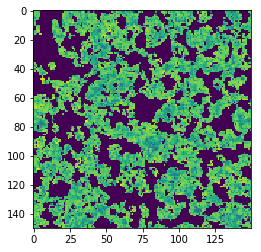

In [8]:
plt.imshow(core_instr.default_ctx.get("lightcone").brightness_temp[:,:, 0])

In [9]:
core_instr.sim_frequencies

array([1.60000000e+08, 1.59754659e+08, 1.59509506e+08, 1.59264544e+08,
       1.59019771e+08, 1.58775188e+08, 1.58530794e+08, 1.58286590e+08,
       1.58042576e+08, 1.57798752e+08, 1.57555115e+08, 1.57311671e+08,
       1.57068414e+08, 1.56825346e+08, 1.56582469e+08, 1.56339781e+08,
       1.56097282e+08, 1.55854974e+08, 1.55612853e+08, 1.55370923e+08,
       1.55129182e+08, 1.54887631e+08, 1.54646268e+08, 1.54405095e+08,
       1.54164114e+08, 1.53923319e+08, 1.53682715e+08, 1.53442299e+08,
       1.53202072e+08, 1.52962035e+08, 1.52722188e+08, 1.52482530e+08,
       1.52243062e+08, 1.52003783e+08, 1.51764692e+08, 1.51525792e+08,
       1.51287079e+08, 1.51048557e+08, 1.50810224e+08, 1.50572080e+08,
       1.50334124e+08, 1.50096360e+08, 1.49858782e+08, 1.49621396e+08,
       1.49384197e+08, 1.49147190e+08])

The sky size (in lm co-ordinates) after tiling/coarsening:

In [10]:
core_instr.sky_size

<Quantity 0.62956416>

The simulated sky after stitching and coarsening (note this code is just copied from the call function, and may change between versions):

Existing z=8.599200000000002 perturb_field boxes found and read in.
Existing z=8.23 perturb_field boxes found and read in.
Existing z=7.875 perturb_field boxes found and read in.
Sampling the data onto baselines


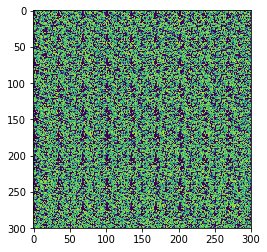

In [11]:
lightcone = core_instr.default_ctx.get("lightcone") #Doing this actually does all of the below, 
                                                    # but the below is not saved to the context...

boxsize = core_instr._base_module.user_params.BOX_LEN
cosmo = core_instr._base_module.cosmo_params.cosmo
EoR_size = ForegroundsBase.get_sky_size(boxsize, core_instr.redshifts, cosmo)

# TODO: stitch stuff together and then coarsen the grid
new_sky = core_instr.stitch_boxes(lightcone.brightness_temp, EoR_size)
if core_instr.n_cells > 0:
    new_sky = core_instr.coarsen_sky(new_sky, n2=core_instr.n_cells)[0]


We can try to look at a single (coarsened) simulation:

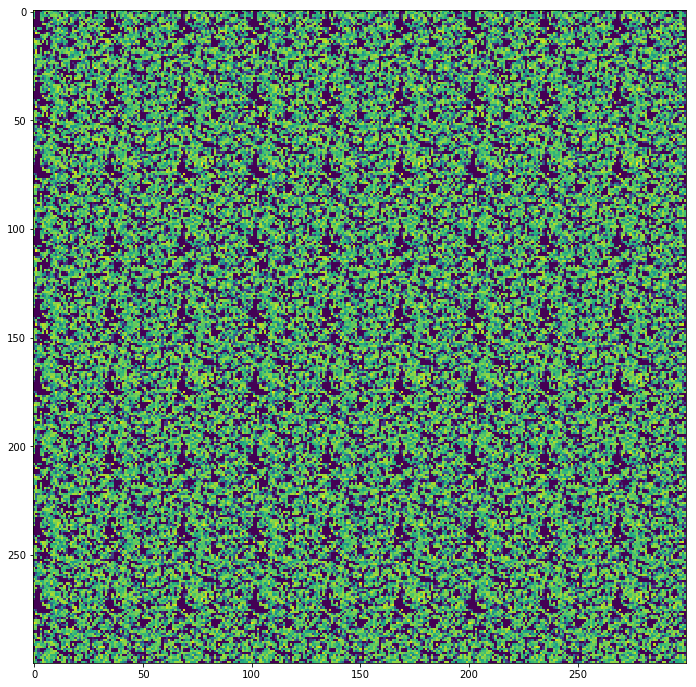

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(new_sky[:,:,0])

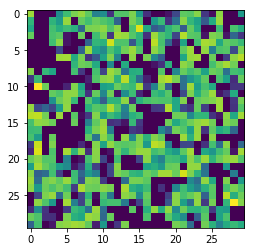

In [14]:
plt.imshow(new_sky[:30,:30,0])

And a gridded power spectrum

In [15]:
power = likelihood.p_data

In [31]:
power

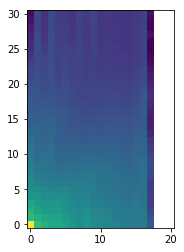

In [16]:
plt.imshow(np.log10(likelihood.p_data.T), origin='lower')

### Analysis

Access the samples object within the chain (see the intro for more details):

In [5]:
samples = analyse.get_samples("data/InstrumentalGridTestNoiseNumerical")

#### Trace Plot

In [6]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

AttributeError: No iterations performed for this run.

#### Corner Plot

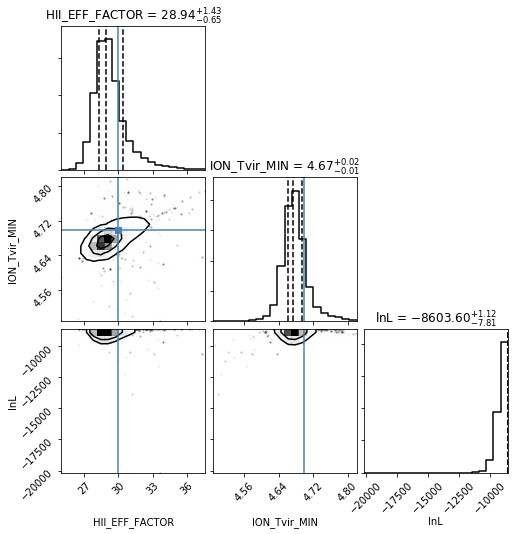

In [12]:
analyse.corner_plot(samples);

## Gridded, Noise, No Foregrounds

In [55]:
modelname = "InstrumentalGridTestNoise"
name = "data/"+modelname

In [4]:
samples = analyse.get_samples(name)
data = np.load(name+'.npz')
noise = np.load(name+".noise.npz")

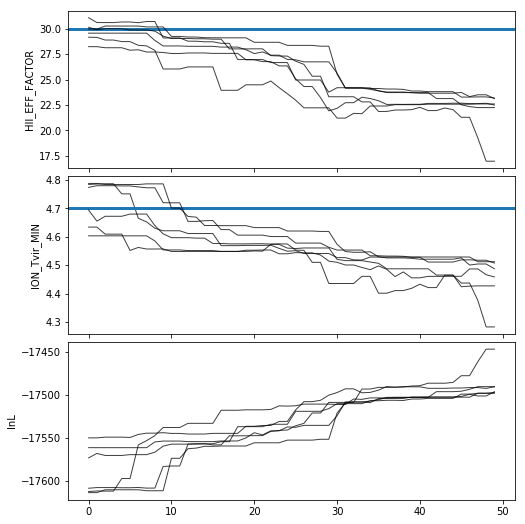

In [5]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

In [6]:
noise = dict(noise)
data = dict(data)
blobs = samples.get_blobs()

ps_extent = (data['u'].min(), data['u'].max(), data['eta'].min(), data['eta'].max())
var = np.array([np.diag(c) for c in noise['covariance']])

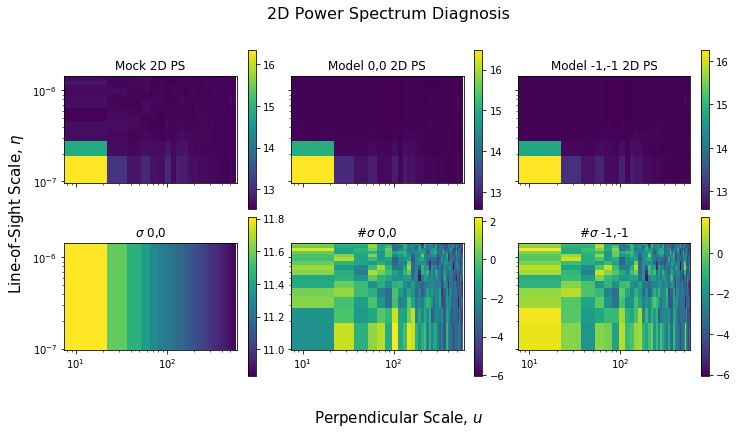

In [25]:
fig,ax = plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True, 
                      subplot_kw={"xscale":"log", "yscale":'log'},
                     gridspec_kw={"hspace":0.05, "wspace":0.05})


im = ax[0,0].imshow(np.log10(data['p_signal'].T), origin='lower', 
           extent=ps_extent)
plt.colorbar(im, ax=ax[0,0]);
ax[0,0].set_title("Mock 2D PS")

im = ax[0,1].imshow(np.log10(blobs['signal'][0,0].T), origin='lower', 
           extent=ps_extent)
plt.colorbar(im, ax=ax[0,1]);
ax[0,1].set_title("Model 0,0 2D PS")

im = ax[0,2].imshow(np.log10(blobs['signal'][-1,-1].T), origin='lower', 
           extent=ps_extent)
plt.colorbar(im, ax=ax[0,2]);
ax[0,2].set_title("Model -1,-1 2D PS")

im = ax[1,0].imshow(np.log10(np.sqrt(var).T), origin='lower', extent=ps_extent)
plt.colorbar(im, ax=ax[1,0]);
ax[1,0].set_title("$\sigma$ 0,0")

im = ax[1,1].imshow(blobs['sigma'][0,0].T, origin='lower', extent=ps_extent)
plt.colorbar(im, ax=ax[1,1]);
ax[1,1].set_title("#$\sigma$ 0,0")

im = ax[1,2].imshow(blobs['sigma'][-1,-1].T, origin='lower', extent=ps_extent)
plt.colorbar(im, ax=ax[1,2]);
ax[1,2].set_title("#$\sigma$ -1,-1")

fig.suptitle("2D Power Spectrum Diagnosis", fontsize=16)

# Add common x,y labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Perpendicular Scale, $u$", labelpad=15, fontsize=15)
plt.ylabel("Line-of-Sight Scale, $\eta$", labelpad=15, fontsize=15);


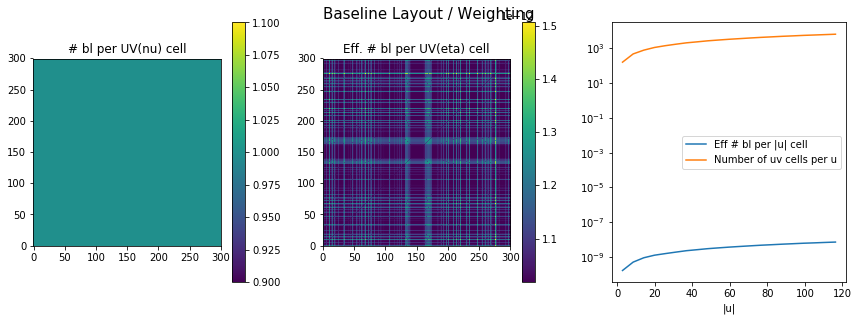

In [102]:
fig, ax = plt.subplots(1,3, figsize=(12,4.5), squeeze=False)

im = ax[0,0].imshow(data['nbl_uvnu'][:,:,0].T, origin="lower")
plt.colorbar(im, ax = ax[0,0])
ax[0,0].set_title("# bl per UV(nu) cell")

im = ax[0,1].imshow(data['nbl_uv'].T, origin="lower")
plt.colorbar(im, ax = ax[0,1])
ax[0,1].set_title("Eff. # bl per UV(eta) cell")

ax[0,2].plot(data['u'], data['nbl_u'], label="Eff # bl per |u| cell")
ax[0,2].plot(data['u'], data['grid_weights'], label="Number of uv cells per u")
ax[0,2].set_xlabel("|u|")
ax[0,2].set_yscale('log')
ax[0,2].legend();

fig.suptitle("Baseline Layout / Weighting", fontsize=15);
plt.tight_layout()

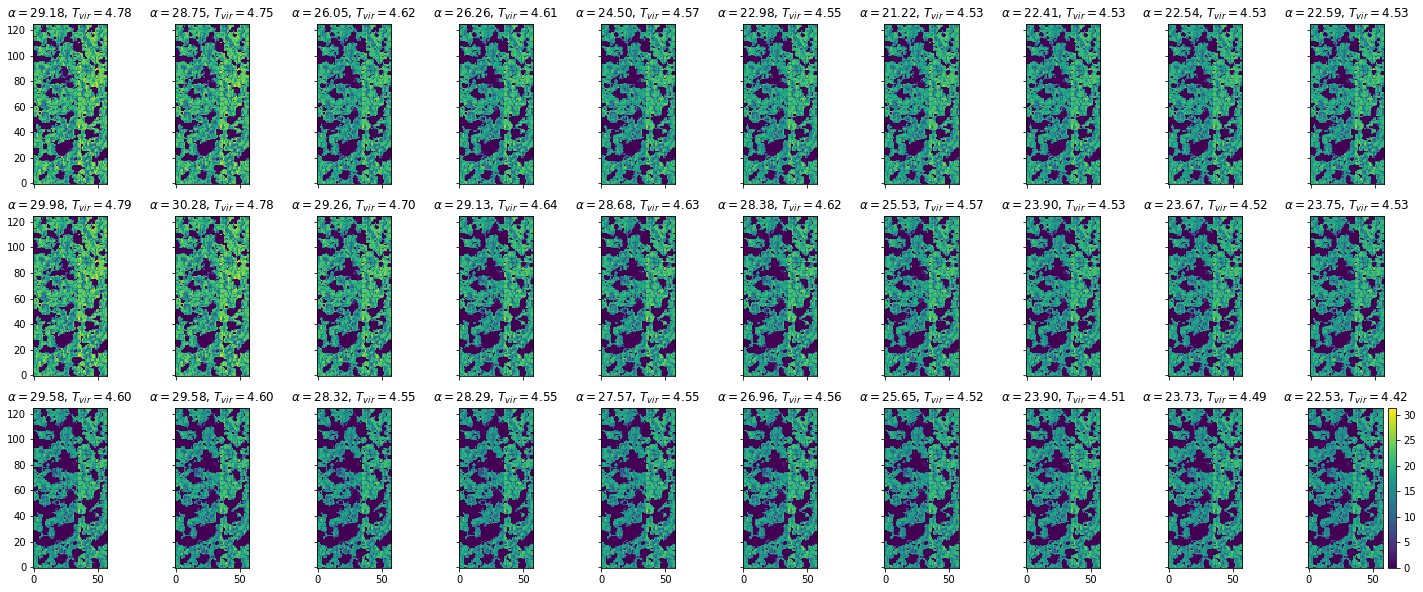

In [22]:
fig,ax =plt.subplots(3, 10, sharex=True, sharey=True, figsize=(25,10))

vmin = np.min(blobs['lc_slices'])
vmax = np.max(blobs['lc_slices'])

for i in range(3):
    for j in range(10):
        jj = j * samples.iteration//10
        
        im = ax[i,j].imshow(blobs['lc_slices'][jj,i], origin='lower', vmin=vmin, vmax=vmax)
        
        ax[i,j].set_title(r"$\alpha=%.2f$, $T_{vir}=%.2f$"%(samples.get_chain()[jj,i, 0], 
                                                            samples.get_chain()[jj,i,1]))
        
plt.colorbar(im, ax=ax[-1,-1])



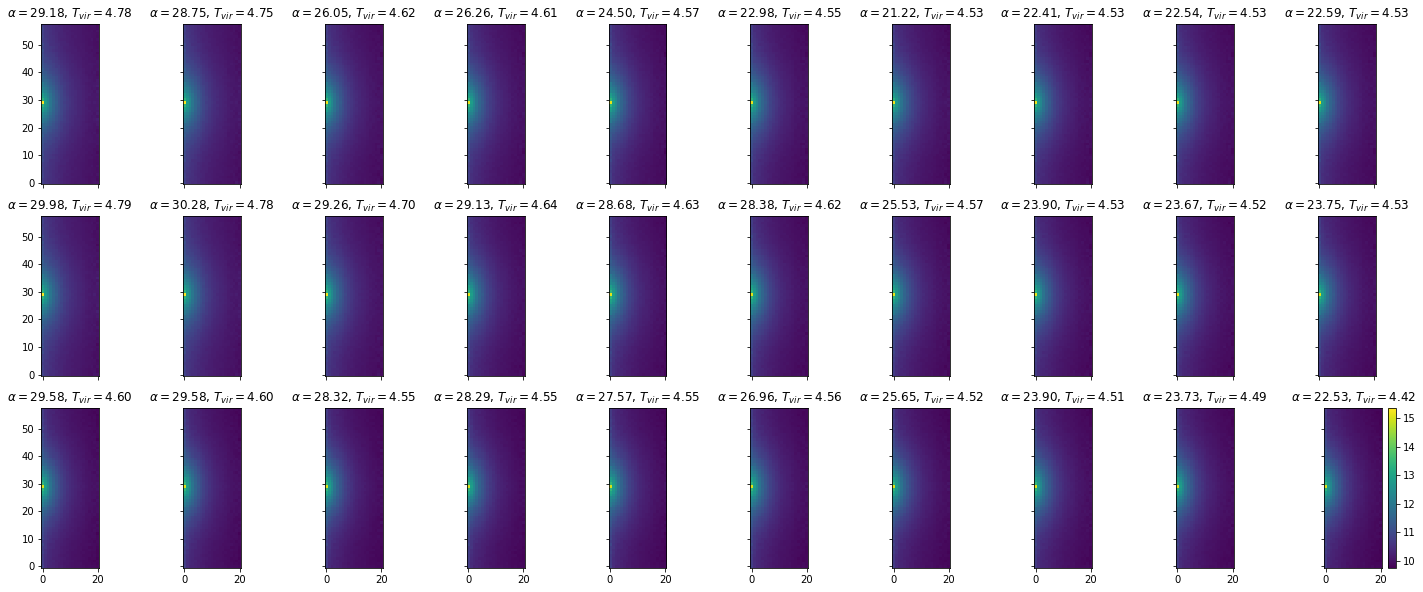

In [24]:
fig,ax =plt.subplots(3, 10, sharex=True, sharey=True, figsize=(25,10))

vmin = np.log10(np.min(blobs['2DPS']))
vmax = np.log10(np.max(blobs['2DPS']))

for i in range(3):
    for j in range(10):
        jj = j * samples.iteration//10
        
        im = ax[i,j].imshow(np.log10(blobs['2DPS'][jj,i].T), origin='lower', vmin=vmin, vmax=vmax)
        
        ax[i,j].set_title(r"$\alpha=%.2f$, $T_{vir}=%.2f$"%(samples.get_chain()[jj,i, 0], 
                                                            samples.get_chain()[jj,i,1]))
        
plt.colorbar(im, ax=ax[-1,-1])


## Gridded, Noise/Numerical, No Foregrounds

### Ingest and Setup data

In [5]:
modelname = "InstrumentalGridTestNoiseNumerical"
name = "data/"+modelname

In [9]:
samples = analyse.get_samples(name)
data = dict(np.load(name+'.npz'))
noise = dict(np.load(name+".noise.npz"))
blobs = samples.get_blobs()

with open(name+".LCC.yml") as f:
    chain = yaml.load(f)
    
lc_core, instr_core = chain.getCoreModules()
lk = chain.getLikelihoodModules()[0]

In [7]:
# Some helpful reduced variables that we can use later.

ps_extent = (data['u'].min(), data['u'].max(), data['eta'].min(), data['eta'].max())
var = np.array([np.diag(c) for c in noise['covariance']])

### Look at the likelihood process

In [10]:
fiducial_context = chain.build_model_data()
fiducial_model = lk.reduce_data(fiducial_context)[0]

(500,)


In [82]:
fiducial_noisy_context = chain.simulate_mock()
fiducial_noisy_model = lk.reduce_data(fiducial_noisy_context)

2019-02-15 15:41:36,422 | INFO | wrapper.py::perturb_field() | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-15 15:41:36,439 | INFO | wrapper.py::perturb_field() | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-15 15:41:37,250 | INFO | wrapper.py::perturb_field() | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-15 15:41:38,073 | INFO | wrapper.py::perturb_field() | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-15 15:41:39,776 | DEBUG | core.py::tile_and_coarsen() | Tiling and coarsening boxes...
2019-02-15 15:41:41,672 | DEBUG | core.py::image_to_uv() | Converting to UV space...
2019-02-15 15:41:42,992 | DEBUG | core.py::add_thermal_noise() | Adding thermal noise...
2019-02-15 15:41:46,404 | DEBUG | core.py::add_thermal_noise() | Adding thermal noise...


(500,)


In [14]:
print(fiducial_context._data.keys())
print(fiducial_model.keys())

dict_keys(['key_parent', 'key_params', 'key_data', 'lightcone', 'visibilities', 'new_sky', 'baselines', 'frequencies'])
dict_keys(['p_signal', 'power1d', 'baselines', 'frequencies', 'u', 'eta', 'nbl_uv', 'nbl_uvnu', 'nbl_u', 'grid_weights', 'uv_grid'])


The first thing in the process is the "true" power spectrum:

In [118]:
def mk_subplot(ax, data, extent, title=None, 
               true_extent=(kperp_orig.min(), kperp_orig.max(),kpar_orig.min(), kpar_orig.max())):
    im = ax.imshow(np.log10(data).T, origin='lower', extent=extent, aspect='auto')
    plt.colorbar(im, ax=ax);
    
    if title: 
        ax.set_title(title)
    
    if true_extent is not None:
        if true_extent[0] > extent[0]:
            ax.axvspan(extent[0], true_extent[0], color='grey', alpha=0.7)

        if true_extent[1] < extent[1]:
            ax.axvspan(true_extent[1], extent[1], color='grey', alpha=0.7)

        if true_extent[2] > extent[2]:
            ax.axhspan(extent[2], true_extent[2], color='grey', alpha=0.7)

        if true_extent[3] < extent[3]:
            ax.axhspan(true_extent[3], extent[3], color='grey', alpha=0.7)    

In [96]:
# Multiply by this to convert an angle on the sky to a transverse distance in
# Mpc/h at redshift z
def dL_dth(z):
    """[h^-1 Mpc]/radian, from Furlanetto et al. (2006)"""
    return 1.9 * (3437.35) * ((1 + z) / 10.0) ** 0.2


# Multiply by this to convert a bandwidth in GHz to a line of sight distance in
# Mpc/h at redshift z
def dL_df(z, omega_m=lc_core.cosmo_params.OMm):
    """[h^-1 Mpc]/GHz, from Furlanetto et al. (2006)"""
    return (1.7 / 0.1) * ((1 + z) / 10.0) ** 0.5 * (omega_m / 0.15) ** -0.5 * 1e3


# Multiply by this to convert a baseline length in wavelengths (at the frequency
# corresponding to redshift z) into a tranverse k mode in h/Mpc at redshift z
def dk_du(z):
    """2pi * [h Mpc^-1] / [wavelengths], valid for u >> 1."""
    return 2 * np.pi / dL_dth(z)  # from du = 1/dth, which derives from du = d(sin(th)) using the small-angle approx


# Multiply by this to convert eta (FT of freq.; in 1/GHz) to line of sight k
# mode in h/Mpc at redshift z
def dk_deta(z):
    """2pi * [h Mpc^-1] / [GHz^-1]"""
    return 2 * np.pi / dL_df(z)

In [107]:
def get_true_ps():
    Peor, kperp, kpar  = get_power(
        fiducial_context._data['lightcone'].brightness_temp, 
        boxlength=fiducial_context._data['lightcone'].lightcone_dimensions,
        res_ndim=2, ignore_zero_mode=True, bin_ave=False
    )
    
    kpar = kpar[0]

    Peor = Peor[:, kpar> 0]
    kpar = kpar[kpar>0]
    kperp = (kperp[1:] + kperp[:-1])/2
    return Peor, kperp, kpar


def get_stitched_ps():
    newsize = instr_core.cell_size * fiducial_context._data['new_sky'].shape[0]

    Pstitched, u, eta  = get_power(
        fiducial_context._data['new_sky'], 
        boxlength=[newsize, newsize, instr_core.instrumental_frequencies.max() - instr_core.instrumental_frequencies.min()],
        res_ndim=2, ignore_zero_mode=True, bin_ave=False, b = 2*np.pi
    )
    eta = eta[0]

    # Take just positive values.
    Pstitched = Pstitched[:, eta> 0]
    eta = eta[eta>0]
    u = (u[1:] + u[:-1])/2
    
    kperp = u * dk_du(lc_core.redshift)
    kpar = eta * dk_deta(lc_core.redshift) * 1e9
    
    return Pstitched, kperp, kpar

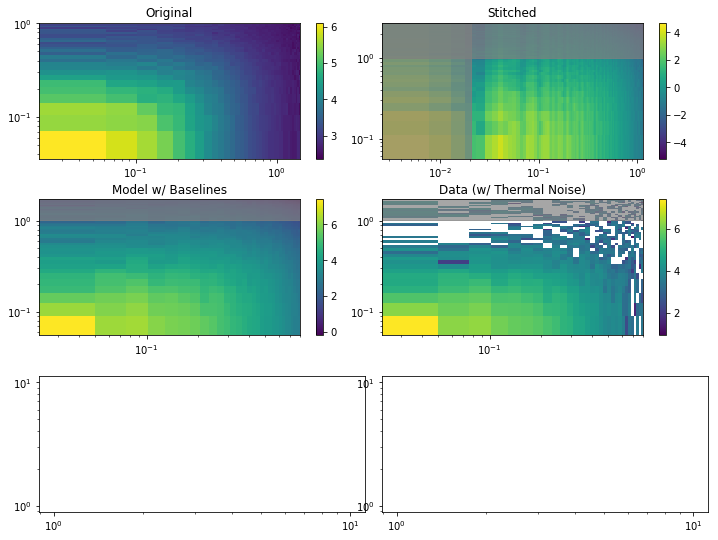

In [119]:
fig, ax = plt.subplots(3,2, figsize=(12,9), subplot_kw={"xscale":'log', "yscale":'log'},
                      gridspec_kw={"wspace":0.05, 'hspace':0.3})



Peor, kperp_orig, kpar_orig = get_true_ps()
mk_subplot(
    ax[0,0], Peor, 
    extent=(kperp_orig.min(), kperp_orig.max(), kpar_orig.min(), kpar_orig.max()),
    title="Original"
)

Pstitched, kperp_stch, kpar_stch = get_stitched_ps()
mk_subplot(
    ax[0,1], Pstitched, 
    extent=(kperp_stch.min(), kperp_stch.max(), kpar_stch.min(), kpar_stch.max()),
    title="Stitched"
)

kperp_mdl = lk.u * dk_du(lc_core.redshift) 
kpar_mdl = data['eta'] * dk_deta(lc_core.redshift)* 1e9
mk_subplot(
    ax[1,0], fiducial_model['p_signal'], 
    extent=(kperp_mdl.min(), kperp_mdl.max(), kpar_mdl.min(), kpar_mdl.max()),
    title="Model w/ Baselines"
)

mk_subplot(
    ax[1,1], fiducial_noisy_model[0]['p_signal'], 
    extent=(kperp_mdl.min(), kperp_mdl.max(), kpar_mdl.min(), kpar_mdl.max()),
    title="Data (w/ Thermal Noise)"
)


This extra power on large scales and less power on small scales due to the taper and beam (probably). 

#### Look at Pixel Distributions

In [84]:
from multiprocessing import Pool

def _produce_mock(i=0):
    """Produces a mock power spectrum for purposes of getting numerical_covariances"""
    ctx = chain.simulate_mock()

    # And compute the power
    power, power1d = lk.compute_power(ctx.get("visibilities"))

    return power, power1d


In [92]:
pool = Pool(6)

nrealisations=100

lc_core.io_options['cache_ionize'] = True
powers, powers1d = zip(*pool.map(_produce_mock, np.random.randint(0,1000000, size=nrealisations)))
lc_core.io_options['cache_ionize'] = False

2019-02-18 12:57:51,181 | INFO | wrapper.py::initial_conditions() | pid=27919 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:57:51,186 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:57:51,145 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:57:51,253 | INFO | wrapper.py::perturb_field() | pid=27919 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:57:51,257 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:57:51,298 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:57:51,298 | INFO | wrapper.py::initial_conditions() | pid=27891 | Existing init_boxes found and read in (seed=736059

2019-02-18 12:57:55,893 | DEBUG | core.py::image_to_uv() | pid=27866 | Converting to UV space...
2019-02-18 12:57:57,429 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 12:57:57,552 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:57:57,686 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 12:57:57,776 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 12:57:57,948 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 12:57:57,961 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 12:58:01,445 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 12:58:01,602 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:58:01,735 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noi

(500,)
(500,)
(500,)
(500,)
(500,)
(500,)


2019-02-18 12:58:19,315 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:58:19,393 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:58:19,442 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:58:19,487 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:58:19,515 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:58:19,541 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:58:19,575 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

2019-02-18 12:58:27,617 | DEBUG | core.py::image_to_uv() | pid=27919 | Converting to UV space...
2019-02-18 12:58:27,773 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:58:28,044 | DEBUG | core.py::image_to_uv() | pid=27878 | Converting to UV space...
2019-02-18 12:58:28,427 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 12:58:28,588 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 12:58:29,098 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 12:58:29,159 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 12:58:29,453 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 12:58:32,002 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:58:32,333 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise..

(500,)
(500,)
(500,)
(500,)
(500,)
(500,)


2019-02-18 12:58:44,540 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:58:44,558 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:58:44,582 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:58:44,613 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:58:44,650 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:58:44,694 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:58:44,737 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

2019-02-18 12:58:57,524 | DEBUG | core.py::image_to_uv() | pid=27919 | Converting to UV space...
2019-02-18 12:58:57,909 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 12:58:58,085 | DEBUG | core.py::image_to_uv() | pid=27891 | Converting to UV space...
2019-02-18 12:58:58,432 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:58:58,555 | DEBUG | core.py::image_to_uv() | pid=27878 | Converting to UV space...
2019-02-18 12:58:59,184 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 12:58:59,811 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 12:59:00,035 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...


(500,)


2019-02-18 12:59:02,220 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 12:59:02,525 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:59:03,256 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 12:59:03,652 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 12:59:03,772 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...


(500,)
(500,)
(500,)
(500,)
(500,)


2019-02-18 12:59:11,278 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:59:11,296 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:11,325 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:11,353 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:59:11,401 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:11,436 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:59:11,471 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

2019-02-18 12:59:24,720 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 12:59:25,609 | DEBUG | core.py::image_to_uv() | pid=27919 | Converting to UV space...
2019-02-18 12:59:25,975 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:59:26,646 | DEBUG | core.py::image_to_uv() | pid=27878 | Converting to UV space...
2019-02-18 12:59:26,762 | DEBUG | core.py::image_to_uv() | pid=27891 | Converting to UV space...
2019-02-18 12:59:27,208 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 12:59:28,273 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...


(500,)


2019-02-18 12:59:28,374 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 12:59:29,041 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 12:59:30,340 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:59:31,128 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 12:59:32,047 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 12:59:32,194 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...


(500,)
(500,)
(500,)


2019-02-18 12:59:38,216 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:59:38,286 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:38,374 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:38,431 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:59:38,467 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:38,492 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:59:38,528 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)
(500,)


2019-02-18 12:59:39,875 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...
2019-02-18 12:59:41,696 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...
2019-02-18 12:59:43,485 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 12:59:46,289 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 12:59:46,350 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:46,420 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 12:59:46,465 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 12:59:46,492 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.

(500,)


2019-02-18 12:59:55,549 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 12:59:55,672 | DEBUG | core.py::image_to_uv() | pid=27878 | Converting to UV space...
2019-02-18 12:59:55,958 | DEBUG | core.py::image_to_uv() | pid=27891 | Converting to UV space...
2019-02-18 12:59:56,644 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 12:59:57,424 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 12:59:57,722 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 12:59:58,235 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 12:59:59,837 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 13:00:01,459 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 13:00:01,535 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise..

(500,)


2019-02-18 13:00:04,799 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:00:04,828 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:04,849 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:04,874 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:04,902 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:04,928 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:04,963 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:00:06,108 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...


(500,)


2019-02-18 13:00:08,103 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...


(500,)
(500,)


2019-02-18 13:00:09,606 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 13:00:13,460 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 13:00:13,614 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:00:13,640 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:13,664 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:13,690 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:13,721 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:13,745 | INFO | wrapper.

(500,)


2019-02-18 13:00:20,781 | INFO | wrapper.py::perturb_field() | pid=27878 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:20,806 | INFO | wrapper.py::ionize_box() | pid=27878 | Existing z=7.875 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:21,670 | DEBUG | core.py::tile_and_coarsen() | pid=27891 | Tiling and coarsening boxes...
2019-02-18 13:00:22,104 | DEBUG | core.py::tile_and_coarsen() | pid=27878 | Tiling and coarsening boxes...
2019-02-18 13:00:22,213 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 13:00:22,644 | DEBUG | core.py::image_to_uv() | pid=27919 | Converting to UV space...
2019-02-18 13:00:23,185 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 13:00:23,829 | DEBUG | core.py::image_to_uv() | pid=27891 | Converting to UV space...
2019-02-18 13:00:24,208 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise

(500,)


2019-02-18 13:00:31,069 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:00:31,084 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:31,115 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:31,144 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:31,209 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:31,237 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:31,272 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:00:34,445 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...


(500,)


2019-02-18 13:00:35,929 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:00:39,834 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:00:39,876 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:39,905 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:39,908 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 13:00:39,938 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:40,008 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:40,038 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2

(500,)


2019-02-18 13:00:48,208 | DEBUG | core.py::tile_and_coarsen() | pid=27919 | Tiling and coarsening boxes...
2019-02-18 13:00:48,594 | DEBUG | core.py::image_to_uv() | pid=27861 | Converting to UV space...
2019-02-18 13:00:49,338 | INFO | wrapper.py::initial_conditions() | pid=27878 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:00:49,357 | INFO | wrapper.py::perturb_field() | pid=27878 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:49,390 | INFO | wrapper.py::perturb_field() | pid=27878 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:49,428 | INFO | wrapper.py::ionize_box() | pid=27878 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:49,473 | INFO | wrapper.py::perturb_field() | pid=27878 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:49,496 | INFO | wrappe

(500,)


2019-02-18 13:00:56,266 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 13:00:57,174 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:00:57,194 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:57,215 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:57,239 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:00:57,267 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:00:57,321 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2

(500,)


2019-02-18 13:01:02,223 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)
(500,)


2019-02-18 13:01:06,284 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:01:06,302 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:06,305 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 13:01:06,334 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:06,375 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:06,423 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:06,464 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2

(500,)


2019-02-18 13:01:12,963 | INFO | wrapper.py::initial_conditions() | pid=27861 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:01:13,033 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:13,101 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:13,141 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:13,170 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:13,192 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:13,226 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:01:22,810 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 13:01:22,950 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 13:01:23,294 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 13:01:23,393 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:01:23,417 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:23,440 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:23,463 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:23,492 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23

(500,)
(500,)


2019-02-18 13:01:32,532 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 13:01:33,641 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:01:33,664 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).


(500,)


2019-02-18 13:01:33,691 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:33,752 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).


(500,)


2019-02-18 13:01:33,827 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:33,849 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:33,902 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:33,973 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=7.875 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:35,116 | DEBUG | core.py::tile_and_coarsen() | pid=27866 | Tiling and coarsening boxes...
2019-02-18 13:01:37,134 | DEBUG | core.py::image_to_uv() | pid=27866 | Converting to UV space...
2019-02-18 13:01:38,672 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...


(500,)


2019-02-18 13:01:41,324 | INFO | wrapper.py::initial_conditions() | pid=27861 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:01:41,340 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:41,363 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:41,388 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:41,417 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:41,440 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:41,481 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:01:50,802 | DEBUG | core.py::add_thermal_noise() | pid=27861 | Adding thermal noise...
2019-02-18 13:01:50,806 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:50,842 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:50,869 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:50,922 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:01:50,971 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=7.875 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:01:52,163 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...
2019-02-18 13:01:52,210 | DEBUG | core.py::add_thermal

(500,)
(500,)


2019-02-18 13:01:59,559 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:02:02,078 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:02:02,095 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:02,117 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:02,148 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:02,186 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:02,214 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:02,251 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:02:07,256 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 13:02:08,332 | INFO | wrapper.py::initial_conditions() | pid=27861 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:02:08,349 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:08,377 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:08,407 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:08,448 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:08,476 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2

(500,)


2019-02-18 13:02:19,338 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...
2019-02-18 13:02:20,074 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 13:02:21,244 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...
2019-02-18 13:02:21,286 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 13:02:22,659 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 13:02:22,798 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:02:27,066 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)


2019-02-18 13:02:29,533 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:02:29,558 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:29,593 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).


(500,)


2019-02-18 13:02:29,626 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:29,662 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:29,701 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:29,732 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:29,757 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=7.875 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:30,993 | DEBUG | core.py::tile_and_coarsen() | pid=27866 | Tiling and coarsening boxes...
2019-02-18 13:02:33,104 | DEBUG | core.py::image_to_uv() | pid=27866 | Converting to UV space...
2019-02-18 13:02:34,607 | DEBUG | core.py::add_thermal_noi

(500,)


2019-02-18 13:02:35,631 | INFO | wrapper.py::initial_conditions() | pid=27861 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:02:35,649 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:35,689 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:35,729 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:35,769 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:35,808 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:35,843 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:02:46,534 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 13:02:47,008 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 13:02:47,585 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...
2019-02-18 13:02:49,121 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 13:02:49,433 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...
2019-02-18 13:02:50,603 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 13:02:50,890 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:02:55,163 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)


2019-02-18 13:02:57,769 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:02:57,787 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).


(500,)


2019-02-18 13:02:57,825 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:57,853 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:57,921 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:57,944 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:57,974 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:02:57,998 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=7.875 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:02:59,156 | DEBUG | core.py::tile_and_coarsen() | pid=27866 | Tiling and coarsening b

(500,)


2019-02-18 13:03:02,622 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 13:03:03,459 | INFO | wrapper.py::initial_conditions() | pid=27861 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:03:03,506 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:03,561 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:03,631 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:03,659 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:03,681 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2

(500,)


2019-02-18 13:03:14,704 | DEBUG | core.py::add_thermal_noise() | pid=27919 | Adding thermal noise...
2019-02-18 13:03:14,917 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...
2019-02-18 13:03:16,869 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...
2019-02-18 13:03:16,934 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 13:03:18,059 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 13:03:18,161 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:03:22,114 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)


2019-02-18 13:03:24,626 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:03:24,647 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).


(500,)


2019-02-18 13:03:24,746 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:24,799 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:24,829 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:24,878 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:24,913 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:24,938 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=7.875 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:26,099 | DEBUG | core.py::tile_and_coarsen() | pid=27866 | Tiling and coarsening b

(500,)


2019-02-18 13:03:29,681 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 13:03:31,098 | INFO | wrapper.py::initial_conditions() | pid=27861 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:03:31,122 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:31,164 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:31,193 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:31,240 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:31,274 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2

(500,)


2019-02-18 13:03:42,830 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...
2019-02-18 13:03:44,214 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 13:03:44,741 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...
2019-02-18 13:03:44,964 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 13:03:46,157 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:03:50,184 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:03:52,882 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:03:52,900 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:52,927 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:52,956 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:52,993 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:53,020 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:53,058 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:03:58,172 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...
2019-02-18 13:03:59,059 | INFO | wrapper.py::initial_conditions() | pid=27861 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:03:59,080 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:59,147 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:03:59,179 | INFO | wrapper.py::ionize_box() | pid=27861 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:03:59,228 | INFO | wrapper.py::initial_conditions() | pid=27919 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:03:59,249 | INFO | wrapper.py::perturb_field() | pid=27861 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
201

(500,)


2019-02-18 13:04:10,477 | DEBUG | core.py::tile_and_coarsen() | pid=27911 | Tiling and coarsening boxes...
2019-02-18 13:04:11,499 | DEBUG | core.py::add_thermal_noise() | pid=27878 | Adding thermal noise...
2019-02-18 13:04:12,261 | DEBUG | core.py::add_thermal_noise() | pid=27891 | Adding thermal noise...
2019-02-18 13:04:12,499 | DEBUG | core.py::image_to_uv() | pid=27911 | Converting to UV space...
2019-02-18 13:04:14,002 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:04:17,872 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...


(500,)
(500,)


2019-02-18 13:04:19,950 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:04:19,980 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:20,008 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:20,037 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:20,102 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:20,127 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:20,158 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:04:26,045 | INFO | wrapper.py::initial_conditions() | pid=27919 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:04:26,082 | INFO | wrapper.py::perturb_field() | pid=27919 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:26,149 | INFO | wrapper.py::perturb_field() | pid=27919 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:26,180 | INFO | wrapper.py::ionize_box() | pid=27919 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:26,214 | INFO | wrapper.py::perturb_field() | pid=27919 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:26,239 | INFO | wrapper.py::ionize_box() | pid=27919 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:26,271 | INFO | wrapper.py::perturb_field() | pid=27919 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:04:36,470 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:04:36,492 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:36,519 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:36,549 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:36,589 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:36,617 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:36,675 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)
(500,)


2019-02-18 13:04:45,367 | DEBUG | core.py::add_thermal_noise() | pid=27911 | Adding thermal noise...
2019-02-18 13:04:46,406 | INFO | wrapper.py::initial_conditions() | pid=27866 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:04:46,418 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).


(500,)


2019-02-18 13:04:46,451 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:46,504 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:46,593 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:46,615 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:04:46,655 | INFO | wrapper.py::perturb_field() | pid=27866 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:04:46,680 | INFO | wrapper.py::ionize_box() | pid=27866 | Existing z=7.875 ionized boxes found and read in (seed=736059577570).


(500,)


2019-02-18 13:04:47,807 | DEBUG | core.py::tile_and_coarsen() | pid=27866 | Tiling and coarsening boxes...
2019-02-18 13:04:49,643 | DEBUG | core.py::image_to_uv() | pid=27866 | Converting to UV space...
2019-02-18 13:04:51,082 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...


(500,)


2019-02-18 13:04:55,222 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...


(500,)


2019-02-18 13:05:03,065 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:05:03,090 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:03,120 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:03,144 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:05:03,171 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:03,192 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:05:03,226 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:05:20,666 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...


(500,)


2019-02-18 13:05:27,473 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:05:27,488 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:27,512 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:27,538 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:05:27,567 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:27,588 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:05:27,623 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:05:45,190 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...


(500,)


2019-02-18 13:05:51,965 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:05:51,983 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:52,009 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:52,042 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:05:52,078 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:05:52,104 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:05:52,139 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:06:09,248 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...


(500,)


2019-02-18 13:06:16,562 | INFO | wrapper.py::initial_conditions() | pid=27911 | Existing init_boxes found and read in (seed=736059577570).
2019-02-18 13:06:16,578 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:06:16,599 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.599200000000002 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:06:16,624 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.599200000000002 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:06:16,659 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=8.23 perturb_field boxes found and read in (seed=736059577570).
2019-02-18 13:06:16,683 | INFO | wrapper.py::ionize_box() | pid=27911 | Existing z=8.23 ionized boxes found and read in (seed=736059577570).
2019-02-18 13:06:16,720 | INFO | wrapper.py::perturb_field() | pid=27911 | Existing z=7.875 perturb_fi

(500,)


2019-02-18 13:06:32,855 | DEBUG | core.py::add_thermal_noise() | pid=27866 | Adding thermal noise...


(500,)


In [125]:
def get_gauss(indx):
    mean = fiducial_model['p_signal'][indx[0], indx[1]]
    var1 = var[indx[0], indx[1]]
    
    x = np.linspace(mean-5*np.sqrt(var1), mean +5*np.sqrt(var1), 100)
    return x, np.exp(-(x - mean)**2 / (2*var1))/np.sqrt(2*np.pi*var1)

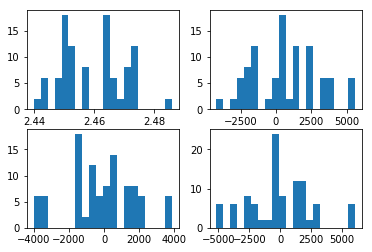

In [128]:
fig, ax = plt.subplots(2,2)

ax[0,0].hist([x[0,0] for x in powers], bins=20);
#x, pdf = get_gauss([0,0])
#ax[0,0].plot(x, pdf*100)

ax[1,0].hist([x[-1,-1] for x in powers], bins=20);
ax[0,1].hist([x[15, 20] for x in powers], bins=20);
ax[1,1].hist([x[25, 30] for x in powers], bins=20);

### Inspect MCMC Chain

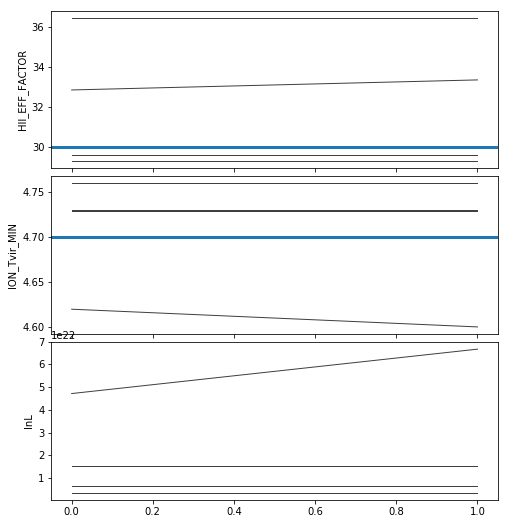

In [4]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

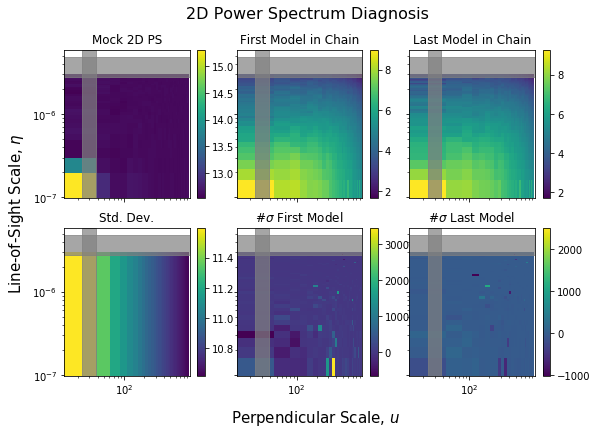

In [81]:
fig,ax = plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True, 
                      subplot_kw={"xscale":"log", "yscale":'log'},
                     gridspec_kw={"hspace":0.2, "wspace":0.1})


mk_subplot(ax[0,0], np.log10(data['p_signal'].T), title="Mock 2D PS")
mk_subplot(ax[0,1], np.log10(blobs['signal'][0,0].T), title="First Model in Chain")
mk_subplot(ax[0,2], np.log10(blobs['signal'][-1,-1].T), title="Last Model in Chain")

mk_subplot(ax[1,0], np.log10(np.sqrt(var).T), title="Std. Dev.")
mk_subplot(ax[1,1], blobs['sigma'][0,0].T, title="#$\sigma$ First Model")
mk_subplot(ax[1,2], blobs['sigma'][-1,-1].T, title="#$\sigma$ Last Model")

fig.suptitle("2D Power Spectrum Diagnosis", fontsize=16)

# Add common x,y labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Perpendicular Scale, $u$", labelpad=15, fontsize=15)
plt.ylabel("Line-of-Sight Scale, $\eta$", labelpad=15, fontsize=15);

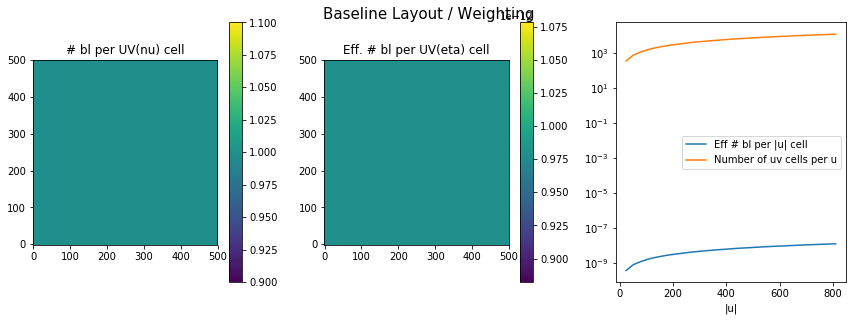

In [46]:
fig, ax = plt.subplots(1,3, figsize=(12,4.5), squeeze=False)

im = ax[0,0].imshow(lk.nbl_uvnu[:,:,0].T, origin="lower")
plt.colorbar(im, ax = ax[0,0])
ax[0,0].set_title("# bl per UV(nu) cell")

im = ax[0,1].imshow(lk.nbl_uv.T, origin="lower")
plt.colorbar(im, ax = ax[0,1])
ax[0,1].set_title("Eff. # bl per UV(eta) cell")

ax[0,2].plot(data['u'], lk.nbl_u, label="Eff # bl per |u| cell")
ax[0,2].plot(data['u'], lk.grid_weights, label="Number of uv cells per u")
ax[0,2].set_xlabel("|u|")
ax[0,2].set_yscale('log')
ax[0,2].legend();

fig.suptitle("Baseline Layout / Weighting", fontsize=15);
plt.tight_layout()